# Fake news classification - Analysis and Modeling

This notebook attempts to analyze the <a href = "https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset">Fake and real news dataset</a>  and model a machine learning algorithm that can classify whether a news article is fake or real.

# Index


<a href="#Statistical-and-Visual-analysis">Statistical and Visual data analysis</a>

<a href="#Data-Preprocessing">Data Preprocessing</a>

<a href="#Machine-Learning-modeling">Machine Learning modeling - Multinomial naive bayes and Support Vector Machines</a>

<a href="#Deep-learning-modeling">Deep learning modeling</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#Regular-dense-neural-network">Regular dense neural network</a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#Recurrent-neural-network---LSTM">Recurrent neural network - LSTM</a>

<a href="#Modeling-over-title">Modeling over title</a>

<a href="#Conclusion">Conclusion</a>

In [1]:
# Importing the libraries.

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
import textstat as ts
from numpy.random import seed
seed(100)


nltk.download('stopwords')


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Importing the dataset.

data_path = "C:\\Users\\mehta\\Desktop\\deeplearning\\projects\\fakenews\\dataset"

true_news_data = pd.read_csv(data_path + "\\True.csv")
fake_news_data = pd.read_csv(data_path + "\\Fake.csv")

# Statistical and Visual analysis

We begin the analysis by calculating the average length of the text in news articles measured in number of words. The average length can be a distinguishing feature among the two categories.

In [3]:
"""
A utility function to calculate the avg. length of the text (in number of words.)

"""

def avg_text_length(dataframe):
    rowCounts = [len(x.split()) for x in dataframe["text"].tolist()]
    avgCount = sum(rowCounts)//len(rowCounts)
    
    return avgCount

In [4]:
print("Avg. text length for true news: {}".format(avg_text_length(true_news_data)))
print("Avg. text length for fake news: {}".format(avg_text_length(fake_news_data)))

Avg. text length for true news: 385
Avg. text length for fake news: 423


We notice that on average, the fake news articles contain about 40 words more than the average true news articles. The average gives us a good measure of the central tendency of the data but let us dive further into the analysis for length of the news articles.

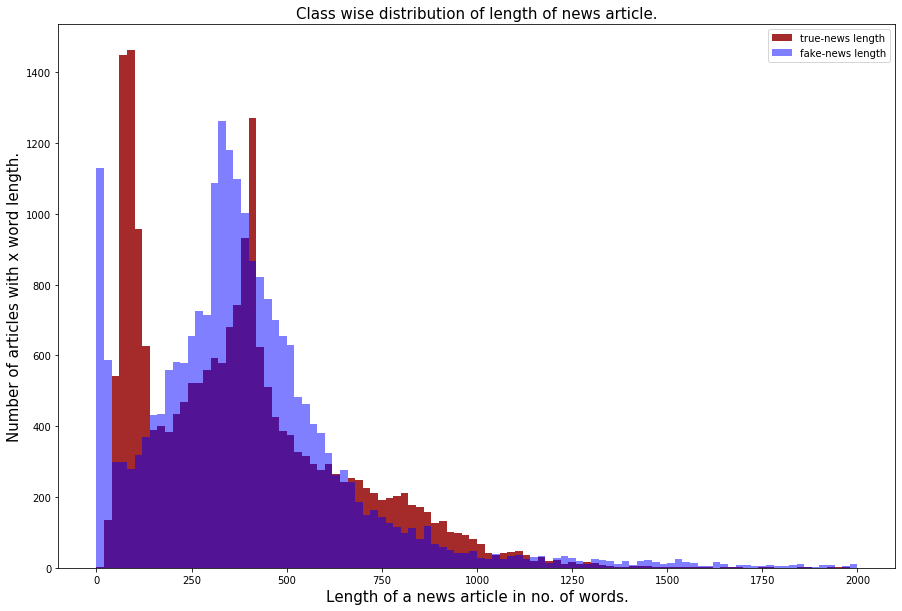

In [5]:
# Plotting the histogram for meaningful insights.

true_lengths = pd.Series([len(x.split()) for x in true_news_data["text"].tolist()])
fake_lengths = pd.Series([len(x.split()) for x in fake_news_data["text"].tolist()])

plt.figure(figsize = (15,10))
plt.hist(true_lengths, bins = 100, range = [0, 2000], color = "brown", label = "true-news length")
plt.hist(fake_lengths, bins = 100, range = [0, 2000], color = "blue", alpha = 0.5, label = "fake-news length")
plt.xlabel("Length of a news article in no. of words.", fontsize = 15)
plt.ylabel("Number of articles with x word length.", fontsize = 15)
plt.title("Class wise distribution of length of news article.", fontsize = 15)
plt.legend()
plt.show()

The above histogram bins the news articles together with same word length and plots the frequency distribution for each word length. The bars in brown shows the frequency distribution of word length of true news articles while the bars in lighter blue shade shows the same for fake news articles. Note that the part of bars in darker blue (more like purple) shade are the areas common to both true and fake news articles.

Some of the insights from this histogram:

1. Rarely, a <b>true</b> news article contains more than 1400 words. On the contrary, there are comparitively much greater number of fake articles with word length more than 1400 words.

2. The mode of the word length of <b>true</b> news articles is somewhere between 200 to 250 words.

3. There are more than 1100 <b>fake</b> news articles with text length equal to 0.

Note: The range of the histogram is set to 2000 because there are extremely less number of news articles with word length greater than 2000.

In [6]:
"""
A utility function to calculate the five number summary of the length of the text of news articles.

"""

def five_num_summary(dataframe):
    quartiles = np.percentile([len(x.split()) for x in dataframe["text"].tolist()], [0, 25, 50, 75, 100])
    
    return quartiles

In [7]:
true_summ = five_num_summary(true_news_data)

print("Text length - five number summary for true news data:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, true_summ[i//25]))
    
    
print("\n")


fake_summ = five_num_summary(fake_news_data)

print("Text length - five number summary for fake news data:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, fake_summ[i//25]))

Text length - five number summary for true news data:
0'th %ile: 0.0
25'th %ile: 148.0
50'th %ile: 359.0
75'th %ile: 525.0
100'th %ile: 5172.0


Text length - five number summary for fake news data:
0'th %ile: 0.0
25'th %ile: 240.0
50'th %ile: 363.0
75'th %ile: 506.0
100'th %ile: 8135.0


Next, we have computed the five-number summary of the word length of true and fake news articles. The five number summary shows the minimum, maximum, the upper quartile, the lower quartile and the median of a data distribution. More on five number summary: https://en.wikipedia.org/wiki/Five-number_summary

We notice that the minimum value for true and fake articles is equal to 0 while the maximum value for fake article is much higher than that of a true news article. The median word length for both fake and true news articles is close to each other.

All the above analysis can show that the average fake news article is going to be somewhat longer than the average true news article.

Another key metric that we can calculate is the frequency of stopwords in the true and fake news articles. Stopwords are the most commonly occuring words in a language data. More on stopwords: https://en.wikipedia.org/wiki/Stop_words

In [8]:
stopwords = nltk.corpus.stopwords.words("english")

"""
A utility function to calculate the average % of stopwords content in true and fake news.

"""

def stopwords_frequency(dataframe):
    words_list = [x.split() for x in dataframe["text"].tolist()]
    frequencies = []
    for row in words_list:
        if(len(row)) > 0:
            row_frequency = len([w for w in row if w in stopwords])
            row_frequency = (row_frequency/len(row))*100

            frequencies.append(row_frequency)
    
    avg = sum(frequencies)/len(frequencies)
    
    return avg

In [9]:
true_frequencies = stopwords_frequency(true_news_data)
fake_frequencies = stopwords_frequency(fake_news_data)

print("Average stopwords frequency in true-news: {}".format(true_frequencies))
print("Average stopwords frequency in fake-news: {}".format(fake_frequencies))

Average stopwords frequency in true-news: 36.12374342655998
Average stopwords frequency in fake-news: 39.509912127071104


We notice that both the true and fake news articles have similar level of stopwords frequency (36% and 39.5% respectively). This means that the frequency of stopwords is not a good distinguisher among the two categories.

In order to check for most frequent words in both the datasets, we plot wordcloud of text contents of both true and fake news data.

True news articles wordcloud.


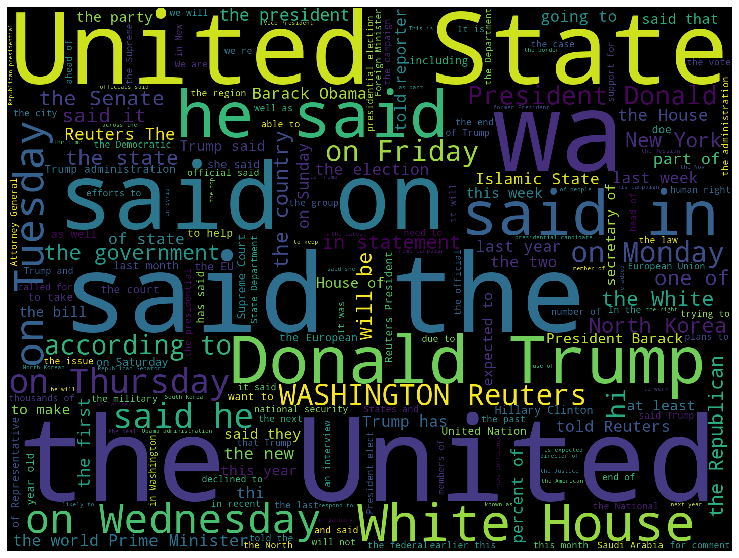

In [10]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(true_news_data["text"].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

print("True news articles wordcloud.")

Fake news articles wordcloud.


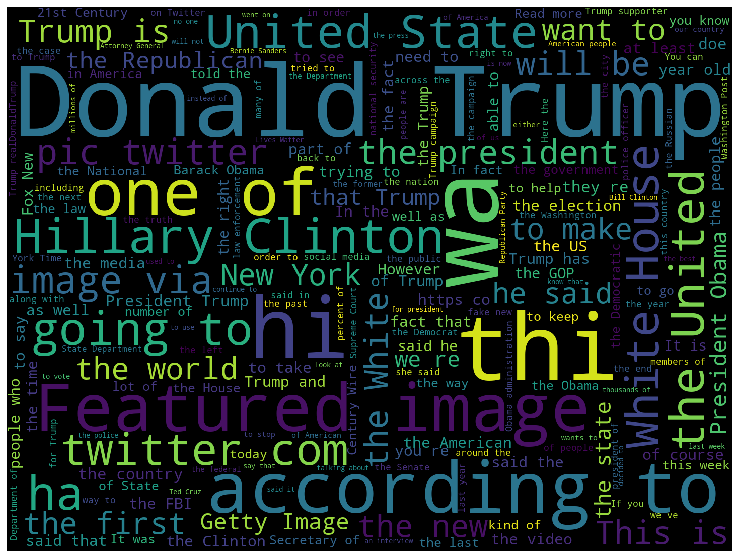

In [11]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(fake_news_data["text"].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

print("Fake news articles wordcloud.")

The above two wordclouds makes some good points about the dataset:

1. The word combination <b>Hillary Clinton</b> occur more frequently in the fake news articles than the true news articles.

2. The word combination <b>the FBI</b> also occur more frequently in the fake news articles as compared to the same in true news articles.

3. The word <b>Reuters</b> has occured many times in the true news articles.

4. The word combination containing the word <b>twitter</b> has occured many times in the fake news dataset. It may be true that a good chunk of fake news articles were associated to the twitter accounts of the subjects in the articles.

We can also experiment with the readability index for each true and fake news articles. 

For readability index, we use Flesch reading ease score formula. The flesch reading ease score determines the level of difficulty of a text. The values of the flesch reading ease score categorizes as:

<b>
90-100 : Very Easy
<br />
80-89 : Easy
<br />
70-79 : Fairly Easy
<br />
60-69 : Standard
<br />
50-59 : Fairly Difficult
<br />
30-49 : Difficult
<br />
0-29 : Very Confusing
</b>

The formula for calculating the flesch reading easiness score is given below:

<i>RE = 206.835 – (1.015 x ASL) – (84.6 x ASW)</i>

<i>RE = Readability Ease</i>

<i>ASL = Average Sentence Length (i.e., the number of words divided by the number of sentences)</i>

<i>ASW = Average number of syllables per word (i.e., the number of syllables divided by the number of words)</i>

In [12]:
true_news_readability = []
fake_news_readability = []

for sentence in true_news_data["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    true_news_readability.append(temp)
    
for sentence in fake_news_data["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    fake_news_readability.append(temp)

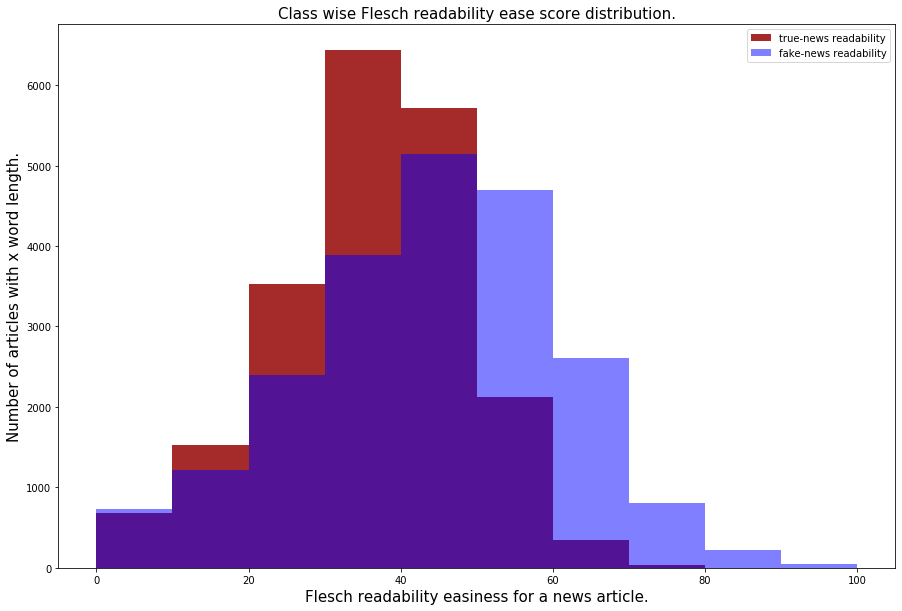

In [13]:
true_readability_df = pd.Series(true_news_readability)
fake_readability_df = pd.Series(fake_news_readability)

plt.figure(figsize = (15,10))
plt.hist(true_readability_df, bins = 10, range = [0, 100], color = "brown", label = "true-news readability")
plt.hist(fake_readability_df, bins = 10, range = [0, 100], color = "blue", alpha = 0.5, label = "fake-news readability")
plt.xlabel("Flesch readability easiness for a news article.", fontsize = 15)
plt.ylabel("Number of articles with x word length.", fontsize = 15)
plt.title("Class wise Flesch readability ease score distribution.", fontsize = 15)
plt.legend()
plt.show()

The above figure shows the frequency distribution of flesch readability score for true and fake news articles. We can notice that:

1. The flesch readability of true news articles is much lesser than the fake news articles.

2. The maximum flesch readability of true news articles goes upto 80 while the maximum flesch readability for fake news articles go upto 100.

Further, we can check for the dates on which the maximum number of fake news articles were released. 

In [14]:
fake_datewise_counts = fake_news_data.groupby('date').date.agg([('count', 'count')]).reset_index().sort_values(by = "count", ascending = False)

fake_datewise_counts = fake_datewise_counts.head(50)

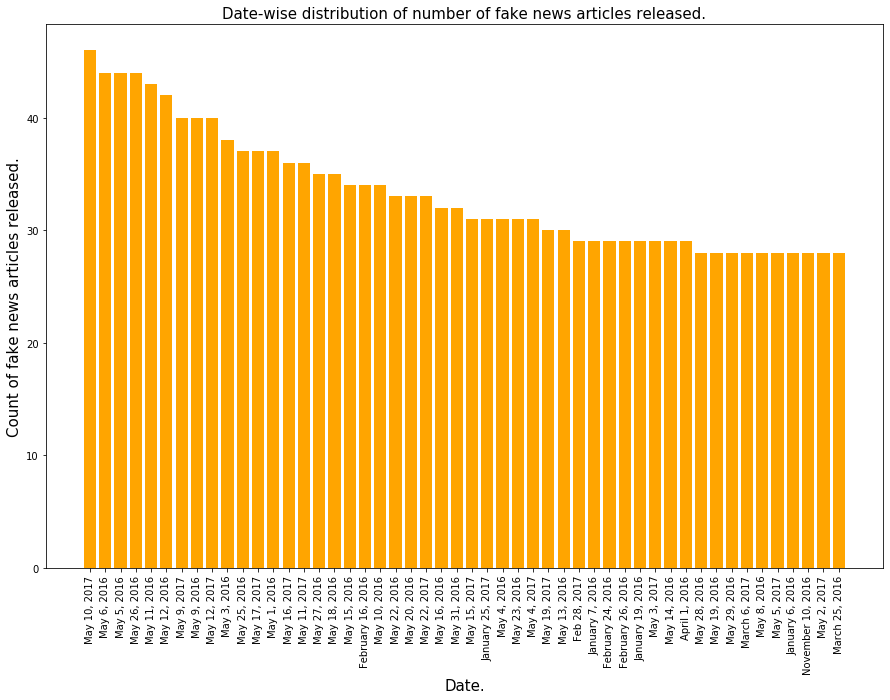

In [100]:
plt.figure(figsize = (15,10))
plt.xticks(rotation = 90)
plt.bar(fake_datewise_counts["date"], fake_datewise_counts["count"], align = "center", color = "orange")
plt.xlabel("Date.", fontsize = 15)
plt.ylabel("Count of fake news articles released.", fontsize = 15)
plt.title("Date-wise distribution of number of fake news articles released.", fontsize = 15)
plt.show()

The above frequency distribution barchart shows that the highest number of fake news articles are released on May 10th, 2017 with more than 40 fake news articles released.

Below are some of the fake news articles that were released on May 10 2017:

In [99]:
fake_news_data.loc[fake_news_data["date"] == "May 10, 2017"]["title"].tolist()[:10]

[' Comey Sources Are Speaking Out; He Was Fired For Two Reasons And They Are Both Frightening (VIDEO)',
 ' Top Dems Take Action To Keep Documents On Russia Investigation Safe From Trump',
 ' Betsy DeVos TOTALLY HUMILIATED During Keynote Speech At Historically Black University',
 ' White Las Vegas Teen Caught On Camera Calling Black Student ‘F*cking N*****’ (VIDEO)',
 ' Trump Meets With Russian Officials One Day After Firing Comey, Bars American Media From The Room',
 ' BOMBSHELL: FBI Admits They Are Directly Investigating Donald Trump',
 ' Trump Explains Why He Fired James Comey, F*cks Up And Admits He Should Be Impeached (VIDEO)',
 ' WATCH: Kellyanne Conway Wore Out Her Welcome On CNN As Soon As She Opened Her Mouth',
 ' Kellyanne Conway Threatens Media: It’s ‘Inappropriate’ To Question Comey’s Firing (VIDEO)',
 ' Advisers Leak What Trump Does When He Sees Russia Scandal On TV — It’s Really, Really Weird']

# Data Preprocessing

In [111]:
# Introducing the label column stating if the news article is True or False.

true_news_data["label"] = "True"
fake_news_data["label"] = "Fake"

all_news_data = true_news_data.append(fake_news_data, ignore_index = True)

For our initial modeling purposes, we intend to classify whether a news article is True or Fake solely from its text, hence we exclude the other features such as date, subject as well as title.

In [112]:
del all_news_data['title']
del all_news_data['subject']
del all_news_data['date']

all_news_data.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,True
1,WASHINGTON (Reuters) - Transgender people will...,True
2,WASHINGTON (Reuters) - The special counsel inv...,True
3,WASHINGTON (Reuters) - Trump campaign adviser ...,True
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,True


For preprocessing, we will use preprocessing functions provided in this amazing kernel: https://www.kaggle.com/vanshjatana/a-simple-guide-to-text-cleaning

In [113]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re


# Preprocessing function definitions


"""
A utility function to remove punctuations from the text.

"""

def remove_punctuations(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text


"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove emojis from the text.

"""

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


stop_words = set(stopwords.words('english'))

"""
A utility function to remove stopwords from the text.

"""

def clean_stopwords(text):
    res = [w for w in text.split() if not w in stop_words]
    res_string = " ".join(str(x) for x in res)
    return res_string


In [115]:
all_news_data_processed = all_news_data.copy()

all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_punctuations(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_nums(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_URL(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_html(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_emoji(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: clean_stopwords(x))

# Shuffling the rows.

all_news_data_processed = all_news_data_processed.sample(frac = 1).reset_index(drop=True).reset_index(drop = True)

all_news_data_processed.head(10)

,text,label
0,This war expect children fight We war leftist ...,Fake
1,The GovernmentOrchestrated Bankruptcies Of Gen...,Fake
2,There lot people lot say internet political pr...,Fake
3,President Trump put North Korea brutal dictato...,Fake
4,BRASILIA Reuters Brazil Supreme Court suspende...,True
5,BEIRUT Reuters Prime Minister Saad alHariri sa...,True
6,Deputy Attorney General Rod Rosenstein doubled...,Fake
7,WASHINGTON Reuters US President Donald Trump s...,True
8,st Century Wire says We learned week US Presid...,Fake
9,Political correctness literally killing Americ...,Fake


Note that we also need to remove the rows with text length = 0.

In [116]:
all_news_data_processed = all_news_data_processed[all_news_data_processed["text"].str.split().str.len().gt(0)]

In [118]:
len(all_news_data_processed)

44267

For our modeling, we perform a train - validation split with 38000 examples in the training set and others in the validation set.

# Machine Learning modeling

In [119]:
train_X = all_news_data_processed.loc[:38000, "text"].values
train_Y = all_news_data_processed.loc[:38000, "label"].values
validation_X = all_news_data_processed.loc[38000:, "text"].values
validation_Y = all_news_data_processed.loc[38000:, "label"].values

Vectorization of textual data is important in text mining. It converts the text into mathematical vectors so that machine learning can be applied on it. In order to vectorize our text data, we use TF-IDF vectorization. More on TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [120]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_X)
validation_vectors = vectorizer.transform(validation_X)

For the machine learning modeling, we will train our data on two algorithms: Multinomial naive bayes and support vector classifier.

1. MultinomialNB is a simple model which is fast and has been demonstrated to be decently accurate in many applications of NLP.

2. Support vector classifier is also another well performing algorithm for classification purposes.

In [121]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import time

start = time.time()

mnb_classifier = MultinomialNB().fit(train_vectors, train_Y)
linear_svc_classifier = SVC(kernel = "linear").fit(train_vectors, train_Y)

end = time.time()

print("Trained 2 models in {} seconds.".format(end - start))

Trained 2 models in 970.9385936260223 seconds.


In [122]:
from  sklearn.metrics  import accuracy_score

mnb_predicted = mnb_classifier.predict(validation_vectors)
linear_svc_predicted = linear_svc_classifier.predict(validation_vectors)


print("Validation accuracy - Multinomial Naive Bayes: {}".format(accuracy_score(validation_Y, mnb_predicted)))
print("Validation accuracy - Linear Support Vector Classifier: {}".format(accuracy_score(validation_Y, linear_svc_predicted)))

Validation accuracy - Multinomial Naive Bayes: 0.9380141010575793
Validation accuracy - Linear Support Vector Classifier: 0.9954465334900118


In [138]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

In [124]:
print("A detailed report on the model performance:")

print("Model type: Multinomial Naive Bayes")
print(classification_report(validation_Y, mnb_predicted))

print("\n")

print("Model type: Support Vector Machines")
print(classification_report(validation_Y, linear_svc_predicted))

A detailed report on the model performance:
Model type: Multinomial Naive Bayes
              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94      3486
        True       0.93      0.94      0.94      3322

    accuracy                           0.94      6808
   macro avg       0.94      0.94      0.94      6808
weighted avg       0.94      0.94      0.94      6808



Model type: Support Vector Machines
              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      3486
        True       0.99      1.00      1.00      3322

    accuracy                           1.00      6808
   macro avg       1.00      1.00      1.00      6808
weighted avg       1.00      1.00      1.00      6808



The above classification report shows that the F1 score for both Fake and True categories from support vector machines is equal to 1 while the same for Multinomial naive bayes is 0.94. Also, the support for both fake and true categories shows that the dataset is nearly balanced ( ~51% fake vs ~49% true).

# Deep learning modeling

Note: The X-axis of the learning curve plots below start with epoch 0 to <i>num_epochs - 1</i> while in my explanation, I have referred it as starting with epoch 1 to <i>num_epochs</i>.

In this modeling, we will first explore how a regular deep neural network and a recurrent neural network - LSTM performs on training over this data.

In [125]:
all_news_data_processed['label'] = all_news_data_processed['label'].map( {'Fake':1, 'True':0} )

all_news_data_processed.head(10)

,text,label
0,This war expect children fight We war leftist ...,1
1,The GovernmentOrchestrated Bankruptcies Of Gen...,1
2,There lot people lot say internet political pr...,1
3,President Trump put North Korea brutal dictato...,1
4,BRASILIA Reuters Brazil Supreme Court suspende...,0
5,BEIRUT Reuters Prime Minister Saad alHariri sa...,0
6,Deputy Attorney General Rod Rosenstein doubled...,1
7,WASHINGTON Reuters US President Donald Trump s...,0
8,st Century Wire says We learned week US Presid...,1
9,Political correctness literally killing Americ...,1


Recall that in our machine learning modeling, we used tf-idf for vectorization. TF-IDF is based on the bag of words model which means that it focuses on frequencies of the words for vectorization and the semantic context in the sequence is lost. This is a major disadvantage of tf-idf based vectorization.

In modeling of neural networks, we make use of word-embeddings which is a learned representation for text where words that have the same meaning have a similar representation. Thus, the word-embeddings do a better job in preserving the context of the text data than the tf-idf based vectors. 

Our deep learning data preprocessing goes as follows:

1. First we distribute the data among train and test sentences.
2. Then we use the Tokenizer class to tokenize the words in our training data and create an indexed corpus.
3. Then we use the tokenizer to encode the sentences in the training and test data into sequences.
4. Next, we perform padding of the sequences which ensures that all the sequences in the dataset are of equal length. It achieves this by padding 0's either at the beginning of the sequence or at the end. 
5. Also, since tokenization will only happen on our training data, what if we encounter a word in the test data which is not present in our vocabulary? To solve this problem, we make use of something called as "OOV token" ( Out Of Vocabulary token) which is basically used by the library as a replacement word to replace the unknown words in the test data.

In [126]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tf.random.set_seed(100)


vocab_size = 1000000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 38000
max_length = 100

# Splitting the train and the test sentences list.

temp = [x for x in all_news_data_processed["text"].tolist()]
train_sentences = temp[:training_size]
test_sentences = temp[training_size:]

# Splitting the train and the test labels list.

temp2 = [x for x in all_news_data_processed["label"].tolist()]
train_labels = temp2[:training_size]
test_labels = temp2[training_size:]


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [127]:
# Conversion to numpy array equivalents

train_padded = np.array(train_padded)
train_labels = np.array(train_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

#### Regular dense neural network

We wish to check and visualize how the training progresses at every epochs. Thus for plotting the learning curves ( accuracy and loss ) we write the following utility function:

In [128]:
"""
A utility function plot learning curves for the trained model.

"""

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

The below dense neural network contains an embedding layer which creates the word-embeddings of the vectors in a <i>embedding_dim</i> dimensional space. The next layer is a pooling layer which basically pools the high dimensional structure of embedding into lower dimensional vector to reduce computational complexity. It is followed by a fully connected dense layer of 24 hidden nodes with ReLU activation. Then there is a final layer with one node with sigmoid activation.


The model uses Adam optimizer for weights optimization to minimize the binary crossentropy loss. More on Adam optimization: https://arxiv.org/pdf/1412.6980.pdf


The model is trained for 10 epochs with an early stopping criteria monitoring the performance of training loss.

In [130]:
# Regular dense neural network with word-embeddings dimension = 5.

embedding_dim = 5

dnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
dnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/10
950/950 [==============================] - 113s 119ms/step - loss: 0.2801 - accuracy: 0.9187 - val_loss: 0.0639 - val_accuracy: 0.9821
Epoch 2/10
950/950 [==============================] - 75s 79ms/step - loss: 0.0337 - accuracy: 0.9917 - val_loss: 0.0282 - val_accuracy: 0.9916
Epoch 3/10
950/950 [==============================] - 74s 78ms/step - loss: 0.0109 - accuracy: 0.9979 - val_loss: 0.0187 - val_accuracy: 0.9943
Epoch 4/10
950/950 [==============================] - 70s 74ms/step - loss: 0.0038 - accuracy: 0.9996 - val_loss: 0.0157 - val_accuracy: 0.9951
Epoch 5/10
950/950 [==============================] - 69s 73ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.0150 - val_accuracy: 0.9953
Epoch 6/10
950/950 [==============================] - 71s 75ms/step - loss: 5.6163e-04 - accuracy: 1.0000 - val_loss: 0.0149 - val_accuracy: 0.9953
Epoch 7/10
950/950 [==============================] - 72s 76ms/step - loss: 2.7119e-04 - accuracy: 1.0000 - val_loss: 0.0152 - val

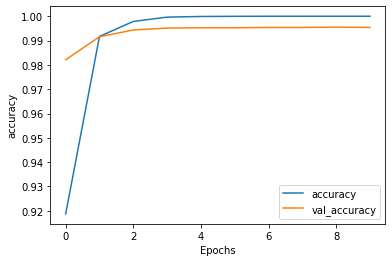

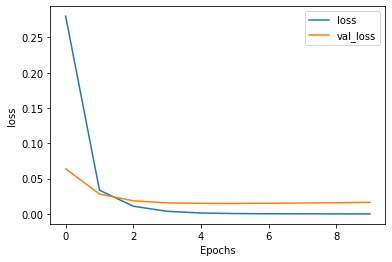

In [131]:
num_epochs = 10

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)

dnn_history = dnn_model.fit(train_padded, train_labels, epochs=num_epochs, validation_split = 0.2, \
                        callbacks = [early_stopping_callback], verbose=1)

plot_graphs(dnn_history, "accuracy")
plot_graphs(dnn_history, "loss")

The above learning curves shows that the loss curve is consistently decreasing and then becomes almost stable. Hence we could have stopped our training process after the epoch 4. The extremely low difference between the training data and validation data also shows that there is no overfitting discovered yet. Let us test the model on our test data vectors.

In [134]:
dnn_results = dnn_model.evaluate(test_padded, test_labels, batch_size=128)

print('Regular dense network - test loss: {}'.format(dnn_results[0]))
print('Regular dense network - test accuracy: {}'.format(dnn_results[1]))

49/49 [==============================] - 0s 1ms/step - loss: 0.0178 - accuracy: 0.9954
Regular dense network - test loss: 0.017810309305787086
Regular dense network - test accuracy: 0.9953725934028625


In [135]:
dnn_pred = (dnn_model.predict(test_padded) >= 0.5).astype("int")

print("A detailed report on the model performance:")

print("Model type: Regular dense neural network.")
print(classification_report(test_labels, dnn_pred))

A detailed report on the model performance:
Model type: Regular dense neural network.
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3056
           1       1.00      0.99      1.00      3211

    accuracy                           1.00      6267
   macro avg       1.00      1.00      1.00      6267
weighted avg       1.00      1.00      1.00      6267



We get a good F1 score for the above trained model which is equal to 1. 

In [150]:
print(confusion_matrix(test_labels, dnn_pred))

[[3045   11]
 [  18 3193]]


The above confusion matrix translates to:

Actual True news & Predicted True news: 3045 <br />
Actual True news but Predicted Fake news: 11 <br />
Actual Fake news but Predicted True news: 18 <br />
Actual Fake news & Predicted Fake news: 3193 <br />

The above confusion matrix shows that there is a decent balance among the true positives, false positives, true negatives and false negatives.

Having evaluated the performance of a dense neural network, let us now experiment by fitting a more complex neural network on the data. LSTM is a recurrent neural network which is capable of learning the dependence of the output on the order of the input sequences. It is used where the training data has a sequential order which might play a crucial role in deciding the class of the sequence in case of classification or generating the next element in the sequence in case of generation. It used in different applications such as machine translation, speech recognition, time-series analysis etc. More on LSTMs: https://en.wikipedia.org/wiki/Long_short-term_memory

#### Recurrent neural network - LSTM

The below neural network contains an embedding layer which creates the word-embeddings of the vectors in a <i>embedding_dim</i> dimensional space. The next layer is a LSTM layer with 12 hidden states. It is followed by a fully connected dense layer of 12 hidden nodes with ReLU activation. Then there is a final layer with one node with sigmoid activation.


This model also uses adam optimization to minimize the binary cross entropy loss with an early stopping criteria monitoring the training loss.

In [141]:
# Recurrent LSTM network with word-embeddings dimension = 10

embedding_dim = 10

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(12),
    tf.keras.layers.Dense(12, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/10
950/950 [==============================] - 148s 156ms/step - loss: 0.3631 - accuracy: 0.8271 - val_loss: 0.1556 - val_accuracy: 0.9534
Epoch 2/10
950/950 [==============================] - 147s 155ms/step - loss: 0.1062 - accuracy: 0.9697 - val_loss: 0.1673 - val_accuracy: 0.9543
Epoch 3/10
950/950 [==============================] - 148s 156ms/step - loss: 0.0955 - accuracy: 0.9720 - val_loss: 0.0858 - val_accuracy: 0.9778
Epoch 4/10
950/950 [==============================] - 157s 166ms/step - loss: 0.1514 - accuracy: 0.9511 - val_loss: 0.2836 - val_accuracy: 0.9113


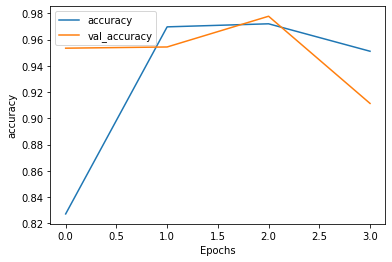

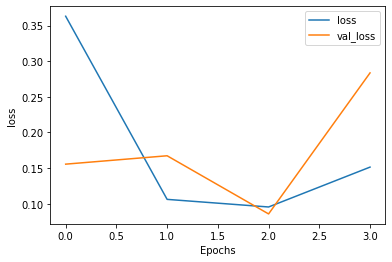

In [142]:
num_epochs = 10

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)

lstm_history = lstm_model.fit(train_padded, train_labels, epochs=num_epochs, validation_split = 0.2, \
                         callbacks = [early_stopping_callback], verbose=1)

plot_graphs(lstm_history, "accuracy")
plot_graphs(lstm_history, "loss")

As you can see in the above learning curve, the validation loss as well as the training loss is inconsistent throughout the training process. The validation loss increases at the first epoch itself. The early stopping criteria was triggered after epoch 4 because the training loss increased instead of decreasing.
<br />
<br />

We know that the regular dense network did well on the dataset. Thus to ensure better training and loss minimization, we add more number of hidden nodes in our first dense layer. Also, in order to regularize the output of the LSTM layer, we add a dropout layer with keep_prob = 0.75. This dropout layer will discard 25% of the output from the LSTM layer and thus introducing some noise in the input feeded to the dense layer. We also add an early stopping criteria callback monitoring the validation loss learning curve in the training below.

Note: Here, the dropout layer is passed a parameter = 0.25 which denotes the rate at which the nodes are to be eliminated.



In [144]:
# Recurrent LSTM network with word-embeddings dimension = 10

embedding_dim = 10

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(12),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(18, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/10
950/950 [==============================] - 165s 174ms/step - loss: 0.2293 - accuracy: 0.9207 - val_loss: 0.1331 - val_accuracy: 0.9678
Epoch 2/10
950/950 [==============================] - 142s 150ms/step - loss: 0.1212 - accuracy: 0.9705 - val_loss: 0.0609 - val_accuracy: 0.9862
Epoch 3/10
950/950 [==============================] - 147s 155ms/step - loss: 0.0419 - accuracy: 0.9907 - val_loss: 0.0439 - val_accuracy: 0.9912
Epoch 4/10
950/950 [==============================] - 147s 155ms/step - loss: 0.0378 - accuracy: 0.9922 - val_loss: 0.0683 - val_accuracy: 0.9828


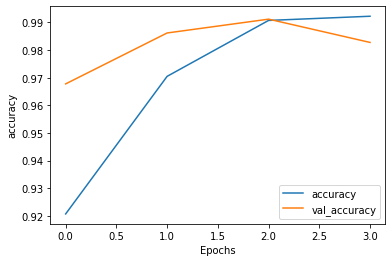

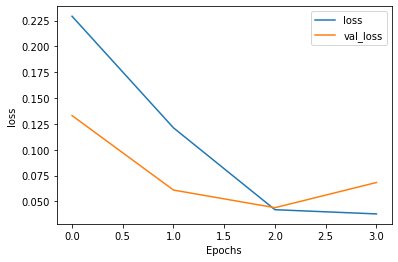

In [145]:
num_epochs = 10

early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(train_padded, train_labels, epochs=num_epochs, validation_split = 0.2, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

plot_graphs(lstm_history, "accuracy")
plot_graphs(lstm_history, "loss")

The above learning curves shows us that the training process in our updated LSTM model is much better as compared to the prior one. The early stopping criteria is met since the validation loss increases at the end of epoch: 4 of the training process. Thus for final modeling, we can simply train our model for 3 epochs instead of 4 which will give us loss minimum on the validation data. Let us check the accuracy of the model on the test data:

In [148]:
lstm_results = lstm_model.evaluate(test_padded, test_labels, batch_size=128)

print('LSTM Model - test loss: {}'.format(lstm_results[0]))
print('LSTM Model - test accuracy: {}'.format(lstm_results[1]))

49/49 [==============================] - 1s 10ms/step - loss: 0.0646 - accuracy: 0.9847
LSTM Model - test loss: 0.06457661092281342
LSTM Model - test accuracy: 0.9846816658973694


In [149]:
lstm_pred = (lstm_model.predict(test_padded) >= 0.5).astype("int")

print("A detailed report on the model performance:")

print("Model type: LSTM recurrent network.")
print(classification_report(test_labels, lstm_pred))

A detailed report on the model performance:
Model type: LSTM recurrent network.
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3056
           1       0.99      0.98      0.98      3211

    accuracy                           0.98      6267
   macro avg       0.98      0.98      0.98      6267
weighted avg       0.98      0.98      0.98      6267



In [151]:
print(confusion_matrix(test_labels, lstm_pred))

[[3033   23]
 [  73 3138]]


The above confusion matrix translates to:

Actual True news & Predicted True news: 3033 <br />
Actual True news but Predicted Fake news: 23 <br />
Actual Fake news but Predicted True news: 73 <br />
Actual Fake news & Predicted Fake news: 3138 <br />

The above confusion matrix shows that there is a fair balance among the true positives, false positives, true negatives and false negatives. 

We thus note that our regular dense neural network performed in a better way than our LSTM model.

We have created a model predicting if a news is fake or not from its text content. Now let us train a deep neural network which will predict if a news is fake or not from its title. This is important because when we see the usecases of this model for a real world fake news classifier application, it is tedious to copy an entire 1000-2000 words length news article and easier to simply copy the title. Therefore we will experiment with a model on the same.

# Modeling over title

In [152]:
all_news_data_title = true_news_data.append(fake_news_data, ignore_index = True)

all_news_data_processed_title = all_news_data_title.copy()

all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_punctuations(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_nums(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_URL(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_html(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_emoji(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: clean_stopwords(x))

all_news_data_processed_title['label'] = all_news_data_processed_title['label'].map( {'Fake':1, 'True':0} )

del all_news_data_processed_title["text"]
del all_news_data_processed_title["subject"]
del all_news_data_processed_title["date"]

all_news_data_processed_title = all_news_data_processed_title[all_news_data_processed_title["title"].str.split().str.len().gt(0)]

all_news_data_processed_title = all_news_data_processed_title.sample(frac = 1).reset_index(drop=True).reset_index(drop = True)

all_news_data_processed_title.head(10)

,title,label
0,Egypt security forces kill suspected militants...,0
1,US watchdog agency review implementation Trump...,0
2,Trump lawyers make final Supreme Court pitch t...,0
3,Ready fight The homeless Rohingya still backin...,0
4,Twitter DESTROYS Trump For Irony Of Screaming ...,1
5,Hong Kong scraps hour BBC World Service radio ...,0
6,“GENTLEMAN” SOLDIER Who Gave Sarah Huckabee Sa...,1
7,Melania Trump Gone AWOL Trump Campaign Totally...,1
8,White House says Flynns Russia plea implicates...,0
9,Col Ralph Peters On Obama’s Refusal To Live In...,1


In [153]:
tf.random.set_seed(100)

temp = [x for x in all_news_data_processed_title["title"].tolist()]
train_sentences_title = temp[:training_size]
test_sentences_title = temp[training_size:]

temp2 = [x for x in all_news_data_processed_title["label"].tolist()]
train_labels_title = temp2[:training_size]
test_labels_title = temp2[training_size:]


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences_title = tokenizer.texts_to_sequences(train_sentences_title)
train_padded_title = pad_sequences(train_sequences_title, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_title = tokenizer.texts_to_sequences(test_sentences_title)
test_padded_title = pad_sequences(test_sequences_title, maxlen=max_length, padding=padding_type, truncating=trunc_type)


train_padded_title = np.array(train_padded_title)
train_labels_title = np.array(train_labels_title)

test_padded_title = np.array(test_padded_title)
test_labels_title = np.array(test_labels_title)

The below dense neural network model is of the same architecture as our previous dense network. The only difference is that this model is fit on the training data containing the title of the news articles and the previous model was trained on the training data containing the text content of the news articles.


The model is trained for 10 epochs with an early stopping criteria monitoring the performance of training loss.
This model also uses adam optimization to minimize the binary cross entropy loss with an early stopping criteria monitoring the training loss.

Epoch 1/10
950/950 [==============================] - 71s 75ms/step - loss: 0.4324 - accuracy: 0.8526 - val_loss: 0.1371 - val_accuracy: 0.9743
Epoch 2/10
950/950 [==============================] - 72s 76ms/step - loss: 0.0813 - accuracy: 0.9809 - val_loss: 0.0674 - val_accuracy: 0.9799
Epoch 3/10
950/950 [==============================] - 72s 76ms/step - loss: 0.0447 - accuracy: 0.9870 - val_loss: 0.0538 - val_accuracy: 0.9824
Epoch 4/10
950/950 [==============================] - 72s 76ms/step - loss: 0.0309 - accuracy: 0.9909 - val_loss: 0.0444 - val_accuracy: 0.9846
Epoch 5/10
950/950 [==============================] - 73s 77ms/step - loss: 0.0225 - accuracy: 0.9935 - val_loss: 0.0402 - val_accuracy: 0.9858
Epoch 6/10
950/950 [==============================] - 74s 78ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.0352 - val_accuracy: 0.9884
Epoch 7/10
950/950 [==============================] - 72s 76ms/step - loss: 0.0129 - accuracy: 0.9963 - val_loss: 0.0426 - val_accuracy:

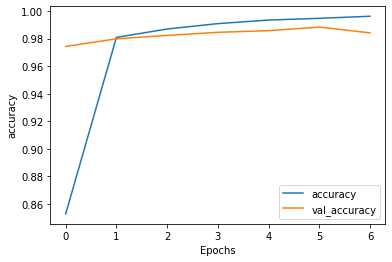

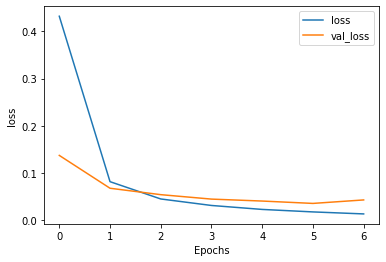

In [163]:
# Regular dense neural network with word-embeddings dimension = 5.

embedding_dim = 5

dnn_model_title = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
dnn_model_title.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs_title = 10

early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

dnn_history_title = dnn_model_title.fit(train_padded_title, train_labels_title, epochs=num_epochs_title, validation_split=0.2,
                        callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

plot_graphs(dnn_history_title, "accuracy")
plot_graphs(dnn_history_title, "loss")

The above learning curves show that the training process was consistent upto epoch 6 and the validation loss increased marginally after training for epoch 7. Thus we have created a decent model on classifying a news article as fake or true based on its title. Moving forward to check the test accuracy and confusion matrix:

In [167]:
dnn_results_title = dnn_model_title.evaluate(test_padded_title, test_labels_title, batch_size=128)

print('Regular dense network - test loss: {}'.format(dnn_results_title[0]))
print('Regular dense network - test accuracy: {}'.format(dnn_results_title[1]))

54/54 [==============================] - 0s 1ms/step - loss: 0.0379 - accuracy: 0.9861
Regular dense network - test loss: 0.037896063178777695
Regular dense network - test accuracy: 0.986082911491394


In [168]:
dnn_pred_title = (dnn_model_title.predict(test_padded_title) >= 0.5).astype("int")

print("A detailed report on the model performance:")

print("Model type: Regular dense neural network.")
print(classification_report(test_labels_title, dnn_pred_title))

A detailed report on the model performance:
Model type: Regular dense neural network.
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3397
           1       1.00      0.98      0.99      3501

    accuracy                           0.99      6898
   macro avg       0.99      0.99      0.99      6898
weighted avg       0.99      0.99      0.99      6898



In [170]:
print(confusion_matrix(test_labels_title, dnn_pred_title))

[[3382   15]
 [  81 3420]]


The above confusion matrix translates to:

Actual True news & Predicted True news: 3382 <br />
Actual True news but Predicted Fake news: 15 <br />
Actual Fake news but Predicted True news: 81 <br />
Actual Fake news & Predicted Fake news: 3420 <br />

The above confusion matrix shows that there is a fair balance among the true positives, false positives, true negatives and false negatives.

# Conclusion

So far, we have analyzed the dataset based on some key metrics of textual data, experimented with machine learning modeling by training the data on multinomial naive bayes, support vector classifiers and then experimented the training of deep learning models such as dense regular networks and LSTM models.
<br />

I hope you have enjoyed the work in this notebook. Thank you for reading :)